In [1]:
import numpy as np
import torch

import gym
from gym import Env
from gym.spaces import Discrete, Box, Dict
from gym.utils import seeding

import random

from agent import PPO
import os
import matplotlib.pyplot as plt

In [2]:
class Heater(Env):
    def __init__(self):

        self.done = False
        self.reward = 0
        self.max_time = 30

        # Action declaration
        self.action_space = Dict({
            "discrete": Discrete(3), # Discrete actions up, down, stay
            "continuous": Box(low=np.array([0., ]), high=np.array([1., ]), dtype=np.float32) 
        })

        # Temperature array
        self.low = np.array([0.,])
        self.high = np.array([100.,])
        self.observation_space = Box(low=self.low, high=self.high, dtype=np.float32)
        
        # Set start temp and start time
        self.reset()
    
    
    def seed(self,seed=None):
        self.np_random, seed = seeding.np_random(seed)

    def step(self, action):
        temp = self.state[0]

        d_action = action["discrete"]

        c_action = action["continuous"]
        c_action = self.interpolation(c_action)[0]
        
        if d_action == 0: # Increase temperature
            temp += c_action
        
        elif d_action == 1: # Decrease temperature
            temp -= c_action
        
        elif d_action == 2:
            temp += 0
        
        # Reward function

        if self.time > 0:
            self.reward -= abs(38.0 - temp) 
            
            if 37.5 <= temp <= 39.0:
                reward = 100
                self.done = True
            
            if abs(38.0 - temp) >= 20:
                reward = -100
                self.done = True

        # Reduce time by 1 second
        self.time -= 1 


        self.state = np.array([temp, ], dtype=np.float32)

        if self.time <= 0:
            self.done = True
            
        # Set placeholder for info
        info = {}
        
        # Return step information
        return self.state, self.reward, self.done, info
    
    def interpolation(self, x):
        # interpolation
        y1 = 0.
        y2 = 5.
        x1 = 0.
        x2 = 1.

        y = y1 + ((y2 - y1)/(x2 - x1))*(x-x1)
        return y

    def render(self):
        # Implement visualization --> in this case is not built
        pass
    
    def reset(self):
        # Reset shower temperature
        temp =  38. + random.randint(-5, 5)
        self.state = np.array([temp, ], dtype=np.float32)

        self.done = False
        self.reward = 0
        
        # Reset shower time
        self.time = self.max_time 
        return self.state


In [3]:
env = Heater()
episodes = 10

for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    temps = []

    while not done:
        action = env.action_space.sample()  
        temp, reward, done, info = env.step(action)
        temps.append(temp) 
        score +=reward
    mean_temp = np.mean(np.array(temps))
    print(f'Episode: {episode}, Mean temperature: {mean_temp:.2f} Score: {score}')

Episode: 1, Mean temperature: 44.23 Score: -2727.767433166504
Episode: 2, Mean temperature: 45.66 Score: -2900.0241622924805
Episode: 3, Mean temperature: 38.93 Score: -5.050968170166016
Episode: 4, Mean temperature: 37.43 Score: -1347.3490600585938
Episode: 5, Mean temperature: 36.17 Score: -28.995670318603516
Episode: 6, Mean temperature: 38.19 Score: -0.18561553955078125
Episode: 7, Mean temperature: 52.03 Score: -3660.348175048828
Episode: 8, Mean temperature: 35.50 Score: -34.496238708496094
Episode: 9, Mean temperature: 30.45 Score: -3146.179733276367
Episode: 10, Mean temperature: 27.04 Score: -2840.098087310791


c:\Users\Lenovo\anaconda3\envs\myenv\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


### Helper functions

In [4]:
def evaluate_policy(env, model, render, steps_per_epoch):
    scores = 0
    turns = 3
    for j in range(turns):
        s, done, ep_r, steps = env.reset(), False, 0, 0
        while not (done or (steps >= steps_per_epoch)):
            # Take deterministic actions at test time
            action_d, action_c = model.evaluate(s)
            action = {
                "discrete": action_d,
                "continuous": action_c 
            }
            s_prime, r, done, info = env.step(action)

            ep_r += r
            steps += 1
            s = s_prime
            if render:
                env.render()
        scores += ep_r
    return scores/turns


def plot_learning_curve(x, scores):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    
    plt.plot(x, running_avg, label="Running average")
    plt.plot(x, scores, alpha=0.4)
    plt.title('Learning plot')
    plt.xlabel("Runs")
    plt.ylabel("Scores")
    plt.legend(loc="best")

### Main training

EnvName: Heater steps: 1k score: -250.1968854268392
EnvName: Heater steps: 2k score: -121.03793970743816
EnvName: Heater steps: 3k score: -1415.7616704305012
EnvName: Heater steps: 4k score: -2044.5863240559895
EnvName: Heater steps: 5k score: -345.2830746968587
EnvName: Heater steps: 6k score: -234.8509839375814
EnvName: Heater steps: 7k score: -335.6322504679362
EnvName: Heater steps: 8k score: -2.8183504740397134
EnvName: Heater steps: 9k score: -124.99877421061198
EnvName: Heater steps: 10k score: -345.24670791625977
EnvName: Heater steps: 11k score: -352.330862681071
EnvName: Heater steps: 12k score: -126.5262845357259
EnvName: Heater steps: 13k score: -125.44368489583333
EnvName: Heater steps: 14k score: -355.18886311848956
EnvName: Heater steps: 15k score: -357.95957946777344
EnvName: Heater steps: 16k score: -350.8069305419922
EnvName: Heater steps: 17k score: -211.6369311014811
EnvName: Heater steps: 18k score: -2.0025405883789062
EnvName: Heater steps: 19k score: -194.7664744

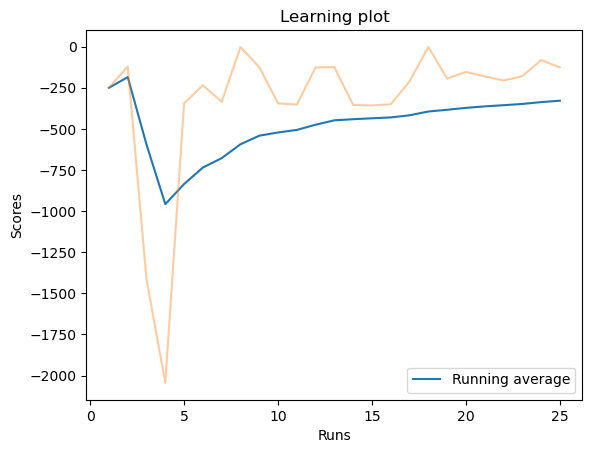

In [5]:
def main():

    random_seed = 0
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    env = Heater()
    env.seed(random_seed)
    
    # Evaluation environment
    eval_env = Heater()
    eval_env.seed(random_seed)

   

    # Hyperparameters
    kwargs = {
        "state_dim": env.observation_space.shape[0], 
        "actions": env.action_space, 
        "env_with_Dead": True,
        "gamma": 0.99, 
        "gae_lambda": 0.95, 
        "policy_clip": 0.2, 
        "n_epochs": 10, 
        "net_width": 256, 
        "lr": 3e-4, 
        "l2_reg": 1e-3, 
        "dist_type": "Beta",
        "batch_size": 64,
        "adv_normalization": True, 
        "entropy_coef": 0, 
        "entropy_coef_decay": 0.9998
    }

    N = 2048 # lenth of long trajectory
    max_steps = env.max_time
    Max_train_steps = 25e3
    save_interval = 1e3
    eval_interval = 1e3
    best_interval = 10e3
    render = False
    best_score = -1000



    if not os.path.exists('model'): 
        os.mkdir('model')
    
    if not os.path.exists('best_model'): 
        os.mkdir('best_model')
    
    model = PPO(**kwargs)
   
    traj_length = 0
    total_steps = 0
    score_history = []
    update = 0
    num_updates = Max_train_steps // N

    while total_steps < Max_train_steps:
        observation, done, steps, score = env.reset(), False, 0, 0

        '''Interact & trian'''
        while not done:
            steps += 1
            traj_length += 1
            total_steps += 1

            action_d, probs_d, action_c, probs_c = model.select_action(observation)
            action = {
                "discrete": action_d,
                "continuous": action_c}
            observation_, reward, done, info = env.step(action)

            if (done and steps != max_steps):
                dw = True  #dw: dead and win
            else:
                dw = False
                        
            model.put_data((observation, action_d, action_c, reward, observation_, probs_d, probs_c, done, dw))
            observation = observation_
            score += reward           

            if traj_length % N == 0:
                a,b,c = model.train()
                traj_length = 0
                update += 1
                
                frac = 1.0 - (update - 1.0) / num_updates
                lrnow = frac * kwargs["lr"]
                model.actor.optimizer.param_groups[0]["lr"] = lrnow
                model.critic.optimizer.param_groups[0]["lr"] = lrnow


            '''record & log'''
            if total_steps % eval_interval == 0:
                score = evaluate_policy(eval_env, model, False, max_steps)
                score_history.append(score)
                print('EnvName: Heater','steps: {}k'.format(int(total_steps/1000)),'score:', score)

            

            '''save model'''
            if total_steps % save_interval==0:
                model.save(total_steps)
            

            ''' best model '''
            if total_steps >= best_interval:
                if score_history[-1] > best_score:
                    best_score = score_history[-1]
                    model.best_save()


    env.close() 
    
    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history)

if __name__ == '__main__':
    main()

### Model testing

In [6]:
# Hyperparameters
env = Heater()
# Hyperparameters
kwargs = {
    "state_dim": env.observation_space.shape[0], 
    "actions": env.action_space, 
    "env_with_Dead": True,
    "gamma": 0.99, 
    "gae_lambda": 0.95, 
    "policy_clip": 0.2, 
    "n_epochs": 10, 
    "net_width": 256, 
    "lr": 3e-4, 
    "l2_reg": 1e-3, 
    "dist_type": "Beta",
    "batch_size": 64,
    "adv_normalization": True, 
    "entropy_coef": 0, 
    "entropy_coef_decay": 0.9998
}


model = PPO(**kwargs)

model.load_best()
scores = []


for i in range(20):
    obs = env.reset()
    actions = []
    score = 0
    while True:
        action_d, action_c = model.evaluate(obs)
        action = {
                    "discrete": action_d,
                    "continuous": action_c 
                }
        obs, reward, done, info = env.step(action)
        score += reward
        actions.append(action)

        if done:
            print(f"Done, points: {score}")
            break
    
    scores.append(score)

print(f"Mean score: {np.mean(scores)}")



Done, points: -306.29326248168945
Done, points: -249.16897201538086
Done, points: -5.005241394042969
Done, points: -368.78086853027344
Done, points: -270.9719467163086
Done, points: -368.78086853027344
Done, points: -306.29326248168945
Done, points: -0.4792900085449219
Done, points: -249.16897201538086
Done, points: -249.16897201538086
Done, points: -270.9719467163086
Done, points: -5.005241394042969
Done, points: -299.5276107788086
Done, points: -342.99909591674805
Done, points: -342.99909591674805
Done, points: -376.0574264526367
Done, points: -306.29326248168945
Done, points: -306.29326248168945
Done, points: -306.29326248168945
Done, points: -249.16897201538086
Mean score: -258.9860416412354
